In [1]:
from typing import Union
from os.path import basename
from dateutil import parser
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from rasters import Raster
from time_conversion import calculate_hour_of_day
from STIC_sensitivity import process_STIC_table
from PTJPL_sensitivity import process_PTJPL_table
from PTJPL.Topt import load_Topt
from PTJPL.fAPARmax import load_fAPARmax
from SEBAL import process_SEBAL_G_table
from harmonized_landsat_sentinel import HLS2SentinelGranule
from sensitivity import perturbed_run, joint_perturbed_run, repeat_rows
from evapotranspiration_conversion import process_daily_ET_table
from mpl_toolkits.mplot3d import Axes3D
from verma_net_radiation_sensitivity.verma_net_radiation_sensitivity import process_verma_net_radiation_table
from evapotranspiration_conversion import process_daily_ET_table

%matplotlib inline

In [2]:
ST_C_filename = "ECOSTRESS_example_rasters/ECOv002_L2T_LSTE_21485_013_11SPS_20220420T211350_0601_01_LST.tif"
ST_C = Raster.open(ST_C_filename) - 273.15
# ST_C

[2024-12-19 12:33:29 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:29 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:33:29 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:29 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [3]:
geometry = ST_C.geometry
# geometry

In [4]:
time_UTC = parser.parse(basename(ST_C_filename).split("_")[6])
# time_UTC

In [5]:
doy = time_UTC.timetuple().tm_yday
# doy

In [6]:
hour_of_day = calculate_hour_of_day(time_UTC, geometry=geometry)
# hour_of_day

In [7]:
emissivity_filename = "../ET-Sensitivity-internal/example_ECOSTRESS_input/ECOv002_L2T_LSTE_21485_013_11SPS_20220420T211350_0601_01/ECOv002_L2T_LSTE_21485_013_11SPS_20220420T211350_0601_01_EmisWB.tif"
emissivity = Raster.open(emissivity_filename)
# emissivity

[2024-12-19 12:33:30 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:30 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:33:30 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:30 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [8]:
sentinel = HLS2SentinelGranule("../ET-Sensitivity-internal/example_ECOSTRESS_input/HLS.S30.T11SPS.2022110T181909.v2.0")
# sentinel

In [9]:
NIR = sentinel.NIR.to_geometry(geometry)
# NIR

In [10]:
red = sentinel.red.to_geometry(geometry)
# red

In [11]:
albedo_filename = "ECOSTRESS_example_rasters/ECOv002_L2T_STARS_21485_013_11SPS_20220420_0700_01_albedo.tif"
albedo = Raster.open(albedo_filename)
# albedo

[2024-12-19 12:33:33 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:33 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:33:33 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:33 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [12]:
Ta_C_filename = "ECOSTRESS_example_rasters/ECOv002_L3T_MET_21485_013_11SPS_20220420T211350_0700_01_Ta.tif"
Ta_C = Raster.open(Ta_C_filename)
# Ta_C

[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [13]:
RH_filename = "ECOSTRESS_example_rasters/ECOv002_L3T_MET_21485_013_11SPS_20220420T211350_0700_01_RH.tif"
RH = Raster.open(RH_filename)
# RH

[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys)

In [14]:
Rn_filename = "ECOSTRESS_example_rasters/ECOv002_L3T_SEB_21485_013_11SPS_20220420T211350_0700_01_Rn.tif"
Rn = Raster.open(Rn_filename)
# Rn

[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:34 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:33:35 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:35 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [15]:
Rg_filename = "../ET-Sensitivity-internal/example_ECOSTRESS_input/ECOv002_L3T_SEB_21485_013_11SPS_20220420T211350_0700_01/ECOv002_L3T_SEB_21485_013_11SPS_20220420T211350_0700_01_Rg.tif"
Rg = Raster.open(Rg_filename)
# Rg

[2024-12-19 12:33:35 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:35 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:33:35 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:35 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [16]:
Topt = load_Topt(geometry)
# Topt

[2024-12-19 12:33:35 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:35 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [17]:
fAPARmax = load_fAPARmax(geometry)
# fAPARmax

[2024-12-19 12:33:36 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:33:36 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [18]:
def reflectance_to_NDVI(NIR: Union[Raster, np.ndarray], red: Union[Raster, np.ndarray]) -> Union[Raster, np.ndarray]:
    return (NIR - red) / (NIR + red)

def reflectance_to_NDVI_table(input_df: pd.DataFrame) -> pd.DataFrame:
    NIR = input_df["NIR"]
    red = input_df["red"]
    NDVI = reflectance_to_NDVI(NIR, red)
    output_df = input_df.copy()
    output_df["NDVI"] = NDVI

    return output_df

def process_verma_PTJPL_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_PTJPL_table(process_verma_net_radiation_table(reflectance_to_NDVI_table(input_df)))


In [19]:
input_df = pd.DataFrame({
    "hour_of_day": hour_of_day.flatten(),
    "lat": geometry.lat.flatten(),
    "lon": geometry.lon.flatten(),
    "NIR": NIR.flatten(),
    "red": red.flatten(),
    "ST_C": ST_C.flatten(),
    "EmisWB": emissivity.flatten(),
    "albedo": albedo.flatten(),
    "Ta_C": Ta_C.flatten(),
    "RH": RH.flatten(),
    "Rn": Rn.flatten(),
    "Rg": Rg.flatten(),
    "Topt": Topt.flatten(),
    "fAPARmax": fAPARmax.flatten()
})

input_df["doy"] = doy
input_df["NDVI"] = (input_df.NIR - input_df.red)/(input_df.NIR + input_df.red)
input_df = input_df.dropna()

ndvi_df = input_df[input_df.NDVI > 0]
sample_df = ndvi_df.sample(5000)
sample_df

,hour_of_day,lat,lon,NIR,red,ST_C,EmisWB,albedo,Ta_C,RH,Rn,Rg,Topt,fAPARmax,doy,NDVI
2159772,13.533207,32.560354,-115.460234,0.2861,0.1223,46.029999,0.948,0.152592,32.975540,0.350364,466.212372,723.077209,18.33,0.2648,110,0.401077
1594984,13.518122,32.790223,-115.686508,0.3272,0.2745,45.649994,0.934,0.183309,30.836369,0.356881,433.560059,715.010803,16.57,0.3907,110,0.087585
321866,13.523542,33.301996,-115.605209,0.3213,0.1211,41.869995,0.938,0.120424,30.178886,0.363660,557.322144,767.833801,17.20,0.1812,110,0.452532
516838,13.550492,33.218522,-115.200954,0.1568,0.1412,45.170013,0.936,0.094635,30.447870,0.349655,493.494476,717.160706,25.48,0.1823,110,0.052349
599777,13.542190,33.186802,-115.325482,0.3509,0.3091,48.250000,0.932,0.212474,29.675627,0.354649,381.002228,720.771179,18.32,0.1826,110,0.063333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927461,13.540624,33.055173,-115.348970,0.5269,0.0513,36.130005,0.966,0.148001,33.258789,0.348821,516.060791,710.690918,19.66,0.3514,110,0.822553
2086052,13.532047,32.590241,-115.477623,0.3117,0.2721,47.089996,0.970,0.177751,32.141205,0.353914,420.594391,724.225098,16.81,0.2494,110,0.067831
1430775,13.539675,32.852705,-115.363203,0.3173,0.1506,40.010010,0.956,0.130529,33.176353,0.348383,511.426697,711.637207,16.39,0.4184,110,0.356273
1810842,13.569892,32.693185,-114.909950,0.3816,0.3210,49.510010,0.882,0.216105,31.335056,0.351446,388.686005,681.913086,29.50,0.2429,110,0.086251


(array([2528., 1161.,  222.,  127.,  141.,  138.,  123.,  113.,  202.,
         245.]),
 array([0.00111607, 0.09279594, 0.18447582, 0.27615569, 0.36783556,
        0.45951544, 0.55119531, 0.64287518, 0.73455506, 0.82623493,
        0.9179148 ]),
 <BarContainer object of 10 artists>)

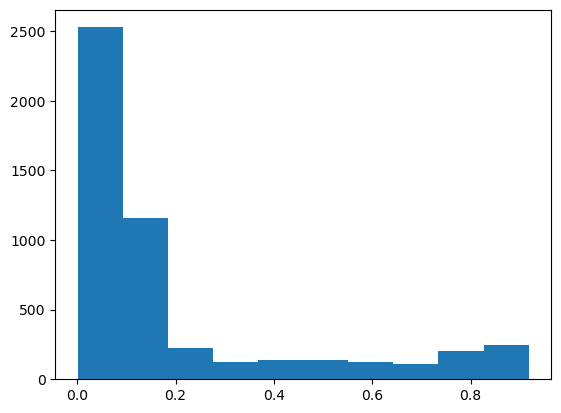

In [20]:
plt.hist(sample_df.NDVI)

In [21]:
input_variable = ["ST_C", "red", "NIR", "albedo", "Ta_C", "RH", "EmisWB", "Rg"]
input_uncertainty = np.array([1.0, 0.03, 0.03, 0.01, 2.67, 0.15, 0.02, 50])

## LST uncert is requirement
## NDVI uncert is conservative estimate from 0.03 err VNIR camera simulations (NIR and Red to NDVI Sensitivity.ipynb)
## abledo is made up as 10% error on average albedo value
## Ta_C is RMSE from Zoe cal-val
## RH is RMSE from Zoe cal-val
## Emissivity is placeholder
## Rg should get from Zoe cal-val, but the variability in this dataset is much lower than Rg RMSE
## Currently uncorrelated uncertainties (could correlated based on empirical correlation of variables)


output_variable = ["LE"]

unperturbed_input, perturbed_input_df, perturbed_output_df, results = joint_perturbed_run(
    input_df=sample_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_PTJPL_table,
    n=100,
    perturbation_mean=np.zeros(8),
    perturbation_cov=np.eye(8) * input_uncertainty ** 2,
    dropna=False
)

kp = (perturbed_input_df.NIR >= 0) & (perturbed_input_df.NIR <= 1) & (perturbed_input_df.red >= 0) & (perturbed_input_df.red <= 1)
ids = results["id"][kp & (perturbed_output_df["LE"] != 0)]

## estimate true ET
repeat_input_df = repeat_rows(sample_df,100)
repeat_input_df = repeat_input_df[kp & (perturbed_output_df["LE"] != 0)]

repeat_verma_df = process_verma_PTJPL_table(repeat_input_df)
repeat_verma_df['Rn'] = repeat_verma_df['Rn'].astype(float) 
repeat_verma_df['LE'] = repeat_verma_df['LE'].astype(float) 
repeat_verma_df['doy'] = repeat_verma_df['doy'].astype(float) 
repeat_verma_df['lat'] = repeat_verma_df['lat'].astype(float) 
repeat_verma_df['hour_of_day'] = repeat_verma_df['hour_of_day'].astype(float) 

true_df = process_daily_ET_table(repeat_verma_df)
true_df["id"] = ids

perturbed_input_df = perturbed_input_df[kp & (perturbed_output_df["LE"] != 0)]
perturbed_output_df = perturbed_output_df[kp & (perturbed_output_df["LE"] != 0)]

### Process perturbed ET
perturbed_output_df['doy'] = perturbed_output_df['doy'].astype(float) 
perturbed_output_df['lat'] = perturbed_output_df['lat'].astype(float) 
perturbed_output_df['hour_of_day'] = perturbed_output_df['hour_of_day'].astype(float) 
perturbed_ET_results = process_daily_ET_table(perturbed_output_df)
perturbed_ET_results["id"] = ids
perturbed_ET_results["ET_perturbation"] = perturbed_ET_results["ET"] - true_df["ET"]

## Process perturbed ET assuming true NDVI
perturbed_input_df['doy'] = perturbed_input_df['doy'].astype(float) 
perturbed_input_df['lat'] = perturbed_input_df['lat'].astype(float) 
perturbed_input_df['hour_of_day'] = perturbed_input_df['hour_of_day'].astype(float) 
perturbed_input_df["red"] = repeat_input_df.red
perturbed_input_df["NIR"] = repeat_input_df.NIR
perturbed_output_df_NDVI = process_verma_PTJPL_table(perturbed_input_df)
perturbed_ET_results_NDVI = process_daily_ET_table(perturbed_output_df_NDVI)
perturbed_ET_results_NDVI["id"] = ids
perturbed_ET_results_NDVI["ET_perturbation"] = perturbed_ET_results_NDVI["ET"] - true_df["ET"]

0


/Users/Maggiej/Documents/GitHub/ET-Sensitivity/verma_net_radiation/verma_net_radiation.py:44: RuntimeWarning: invalid value encountered in sqrt
  eta2 = -(1.2 + 3 * eta1) ** 0.5
/Users/Maggiej/Documents/GitHub/ET-Sensitivity/vegetation_conversion/vegetation_conversion.py:45: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)
/Users/Maggiej/Documents/GitHub/ET-Sensitivity/verma_net_radiation/verma_net_radiation.py:44: RuntimeWarning: invalid value encountered in sqrt
  eta2 = -(1.2 + 3 * eta1) ** 0.5


In [22]:
sample_df_big = input_df.sample(50000)
sample_df_big[input_variable].corr()

,ST_C,red,NIR,albedo,Ta_C,RH,EmisWB,Rg
ST_C,1.000000,0.698291,-0.047535,0.548456,-0.221437,-0.346559,-0.518749,-0.249826
red,0.698291,1.000000,0.260370,0.909085,-0.467415,0.160277,-0.579431,-0.405114
NIR,-0.047535,0.260370,1.000000,0.611839,0.315589,-0.101939,-0.282753,-0.342858
albedo,0.548456,0.909085,0.611839,1.000000,-0.270439,0.102181,-0.590354,-0.468144
Ta_C,-0.221437,-0.467415,0.315589,-0.270439,1.000000,-0.675011,0.157726,-0.216248
RH,-0.346559,0.160277,-0.101939,0.102181,-0.675011,1.000000,0.136347,0.253841
EmisWB,-0.518749,-0.579431,-0.282753,-0.590354,0.157726,0.136347,1.000000,0.502099
Rg,-0.249826,-0.405114,-0.342858,-0.468144,-0.216248,0.253841,0.502099,1.000000


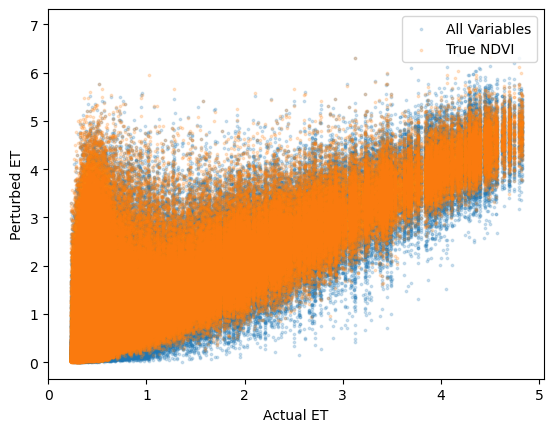

In [23]:
plt.scatter(x=true_df.ET, y=perturbed_ET_results.ET,label="All Variables", alpha=0.2, s=3)
plt.scatter(x=true_df.ET, y=perturbed_ET_results_NDVI.ET,label="True NDVI", alpha=0.2, s=3)
plt.xlabel("Actual ET")
plt.ylabel("Perturbed ET")
plt.legend(loc='upper right')

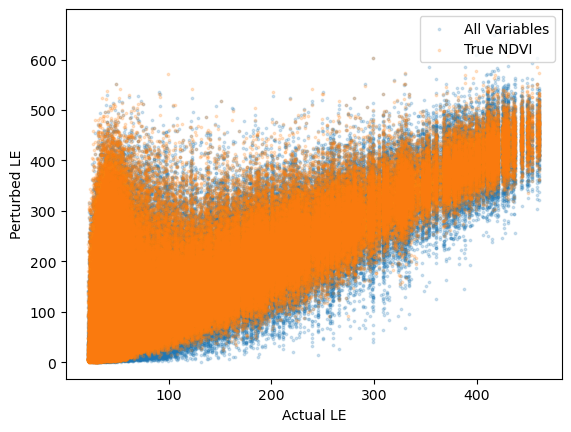

In [24]:
plt.scatter(x=true_df.LE, y=perturbed_output_df.LE,label="All Variables", alpha=0.2, s=3)
plt.scatter(x=true_df.LE, y=perturbed_output_df_NDVI.LE,label="True NDVI", alpha=0.2, s=3)
plt.xlabel("Actual LE")
plt.ylabel("Perturbed LE")
plt.legend(loc='upper right')

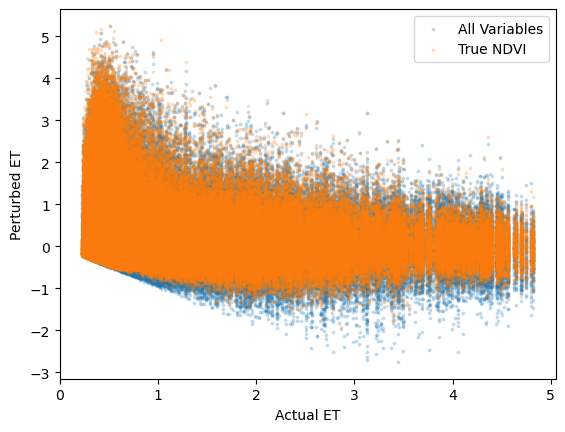

In [25]:
plt.scatter(x=true_df.ET, y=perturbed_ET_results.ET_perturbation,label="All Variables", alpha=0.2, s=3)
plt.scatter(x=true_df.ET, y=perturbed_ET_results_NDVI.ET_perturbation,label="True NDVI", alpha=0.2, s=3)
plt.xlabel("Actual ET")
plt.ylabel("Perturbed ET")
plt.legend(loc='upper right')

(0.0, 1.0)

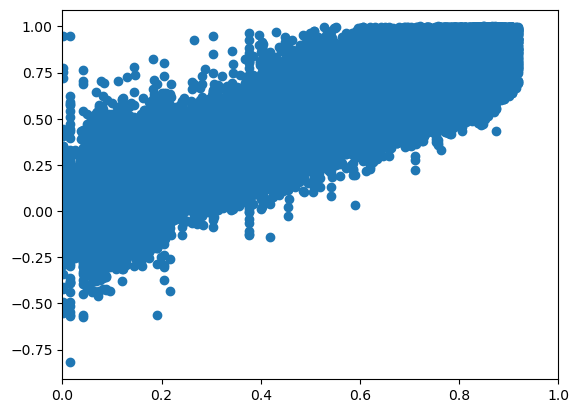

In [26]:
perturbed_NDVI = (perturbed_output_df.NIR - perturbed_output_df.red)/(perturbed_output_df.NIR + perturbed_output_df.red)
true_NDVI = (repeat_input_df.NIR - repeat_input_df.red)/(repeat_input_df.NIR + repeat_input_df.red)
plt.scatter(true_NDVI, perturbed_NDVI)
plt.xlim((0,1))

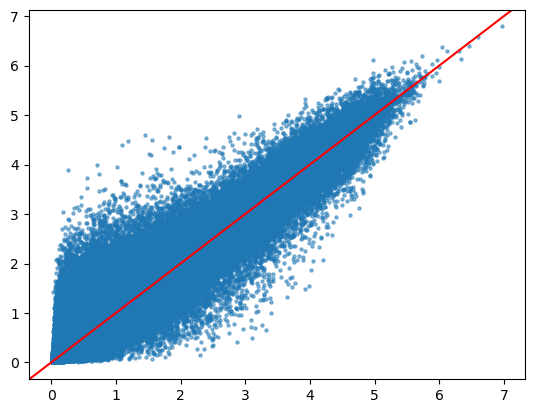

In [27]:
plt.scatter(x=perturbed_ET_results_NDVI.ET, y=perturbed_ET_results.ET, s=5, alpha=0.5)
plt.axline((0, 0), slope=1, c="red")
# plt.hist(true_df.ET,alpha=0.5)

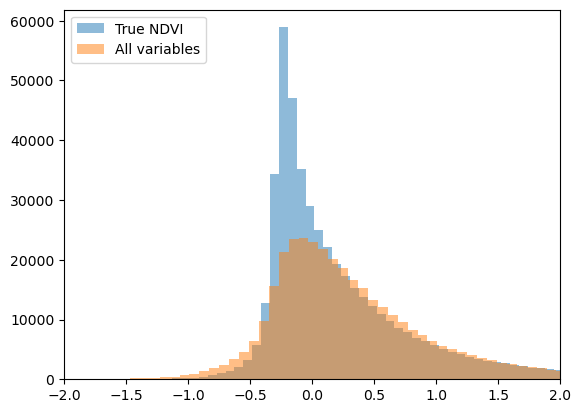

In [28]:
plt.hist(perturbed_ET_results_NDVI.ET_perturbation, alpha=0.5,bins=100, label="True NDVI")
plt.hist(perturbed_ET_results.ET_perturbation, alpha=0.5,bins=100, label="All variables")
plt.xlim((-2,2))
plt.legend(loc='upper left')

In [29]:
results_list = [y for x, y in perturbed_ET_results.groupby('id')]
results_ndvi_true_list = [y for x, y in perturbed_ET_results_NDVI.groupby('id')]

sd_vars = [np.nanstd(y.ET_perturbation,axis=0) for y in results_list]
et_vars = [np.nanmean(y.ET,axis=0) for x,y in true_df.groupby('id')]

sd_true_vars = [np.nanstd(y.ET_perturbation,axis=0) for y in results_ndvi_true_list]

prop_var = np.divide(np.array(sd_true_vars)**2, np.array(sd_vars)**2)

/Users/Maggiej/opt/anaconda3/envs/sensitivity/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_66605/1901677602.py:5: RuntimeWarning: Mean of empty slice
  et_vars = [np.nanmean(y.ET,axis=0) for x,y in true_df.groupby('id')]


Text(0, 0.5, 'Total ET RMSE (mm/day)')

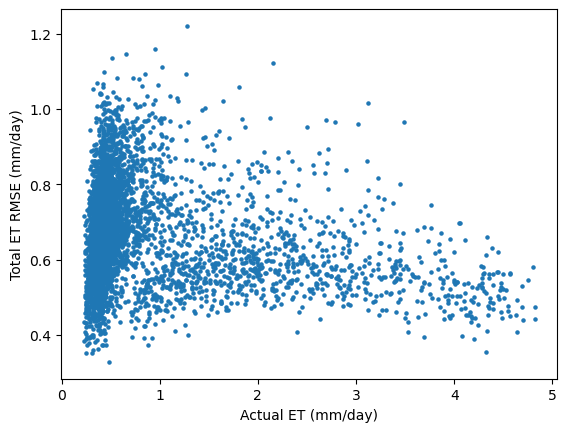

In [30]:
plt.scatter(x=et_vars, y=sd_vars,s=5)
plt.xlabel("Actual ET (mm/day)")
plt.ylabel("Total ET RMSE (mm/day)")

In [31]:
np.sqrt(np.nanmean(perturbed_ET_results.ET_perturbation**2,axis=0)) ## overall rmse

0.7802262100803079

In [32]:
np.sqrt(np.nanmean(perturbed_ET_results_NDVI.ET_perturbation**2,axis=0)) ## overall rmse true NDVI

0.7128177887359854

In [33]:
np.nanmean(perturbed_ET_results_NDVI.ET_perturbation**2,axis=0)/np.nanmean(perturbed_ET_results.ET_perturbation**2,axis=0)

0.8346722742065179

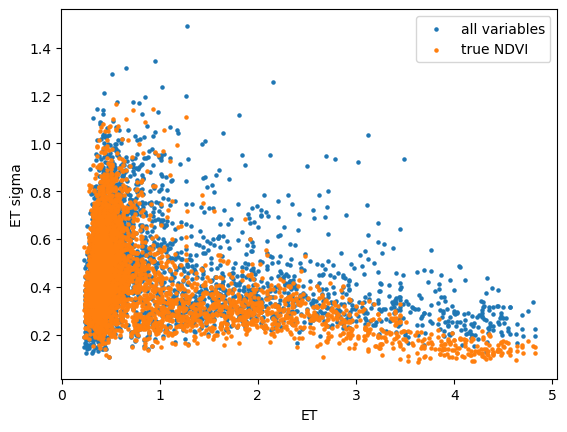

In [34]:
plt.scatter(x=et_vars, y=np.array(sd_vars)**2,s=5, label="all variables")
plt.scatter(x=et_vars, y=np.array(sd_true_vars)**2, s=5, label="true NDVI")
plt.xlabel("ET")
plt.ylabel("ET sigma")
plt.legend(loc='upper right')

Text(0, 0.5, 'Prop Var due to NDVI error')

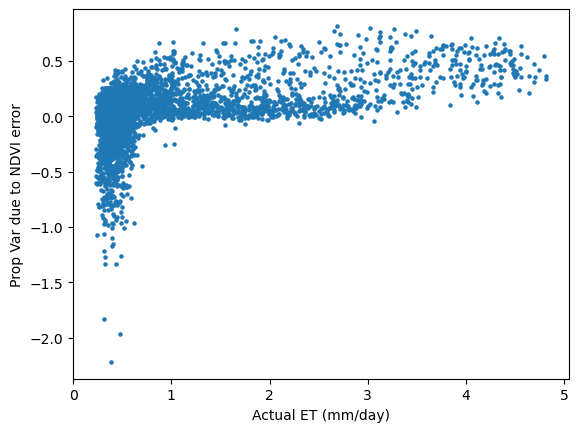

In [35]:
plt.scatter(x=et_vars, y= 1 - prop_var,s=5)
plt.xlabel("Actual ET (mm/day)")
plt.ylabel("Prop Var due to NDVI error") ## negatives are artifacts of all variable errors larger than true ndvi

/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_66605/1818272770.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter(x=et_vars, y=np.sqrt(np.array(sd_vars)**2 - np.array(sd_true_vars)**2),s=5)


Text(0, 0.5, 'ET RMSE due to NDVI (mm/day)')

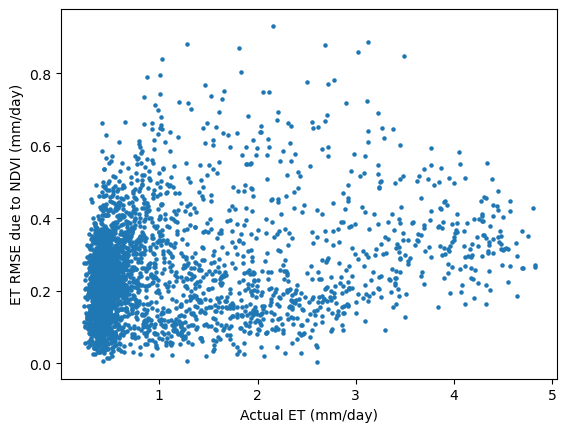

In [36]:
plt.scatter(x=et_vars, y=np.sqrt(np.array(sd_vars)**2 - np.array(sd_true_vars)**2),s=5)
plt.xlabel("Actual ET (mm/day)")
plt.ylabel("ET RMSE due to NDVI (mm/day)")
